In [ ]:
 import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import cv2
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
CURRENT = r"/content/gdrive/MyDrive/Eye"
# PATH = r"/content/gdrive/MyDrive/Neural Nets/Eye/train_images_resized_preprocessed"

In [ ]:
def load_data():
    os.chdir(CURRENT)
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_valid', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [ ]:
df_train_train, df_train_test = load_data()

In [ ]:
df_train_train

,id_code,diagnosis,file_path,file_name
2295,a125377fb985,2,./train_images/a125377fb985.png,a125377fb985.png
1672,7663aba8d762,2,./train_images/7663aba8d762.png,7663aba8d762.png
3299,e50b0174690d,0,./train_images/e50b0174690d.png,e50b0174690d.png
249,12b57dac703e,0,./train_images/12b57dac703e.png,12b57dac703e.png
3438,eedae6b28f96,0,./train_images/eedae6b28f96.png,eedae6b28f96.png
...,...,...,...,...
3358,e933923aab15,0,./train_images/e933923aab15.png,e933923aab15.png
2184,999ad827ed35,0,./train_images/999ad827ed35.png,999ad827ed35.png
173,0ceb222f6629,4,./train_images/0ceb222f6629.png,0ceb222f6629.png
2519,ae94ce412de9,0,./train_images/ae94ce412de9.png,ae94ce412de9.png


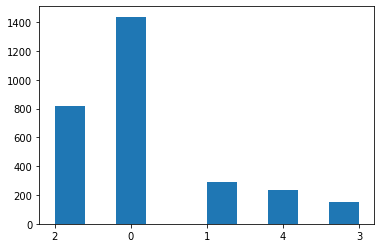

In [ ]:
plt.hist(df_train_train['diagnosis'])
plt.show()

In [ ]:
BATCH_SIZE = 50
HEIGHT = 224
WIDTH = 224

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split = 0.0) #rotation_range=30,fill_mode='nearest',horizontal_flip=True
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.99999)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory="./valid_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

Found 2929 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [ ]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
)

219055592/219055592 [==============================] - 13s 0us/step


In [ ]:
def CNN(model):
    x = model.outputs[-1]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(5, activation="softmax")(x)

    model = models.Model(inputs=model.inputs, outputs=x)
    return model

In [ ]:
model = CNN(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
HIST = []
for epoch, lr in zip([1, 5, 3], [1e-3, 1e-4, 1e-5]):  
  model.compile(optimizer=Adam(learning_rate=lr), loss=CategoricalCrossentropy(), metrics="accuracy")
  history = model.fit(train_generator, epochs=epoch, validation_data = valid_generator, verbose=1)
  HIST.append(history)

59/59 [==============================] - 2476s 40s/step - loss: 0.7567 - accuracy: 0.7221 - val_loss: 9.0948 - val_accuracy: 0.5314
Epoch 1/5
59/59 [==============================] - 148s 1s/step - loss: 0.4960 - accuracy: 0.8057 - val_loss: 0.5670 - val_accuracy: 0.7691
Epoch 2/5
59/59 [==============================] - 58s 977ms/step - loss: 0.3762 - accuracy: 0.8542 - val_loss: 0.5419 - val_accuracy: 0.8019
Epoch 3/5
59/59 [==============================] - 61s 1s/step - loss: 0.2476 - accuracy: 0.9037 - val_loss: 0.6992 - val_accuracy: 0.7910
Epoch 4/5
59/59 [==============================] - 58s 981ms/step - loss: 0.1687 - accuracy: 0.9375 - val_loss: 0.6038 - val_accuracy: 0.7896
Epoch 5/5
59/59 [==============================] - 58s 975ms/step - loss: 0.1074 - accuracy: 0.9655 - val_loss: 0.9143 - val_accuracy: 0.7814
Epoch 1/3
59/59 [==============================] - 148s 1s/step - loss: 0.0638 - accuracy: 0.9816 - val_loss: 0.8532 - val_accuracy: 0.7978
Epoch 2/3
59/59 [======

In [ ]:
np.save("./ResInceptioNet50_history.npy", np.array(HIST))
model.save("./ResInceptionNet50.h5")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_100
.........vars
......activation_101
.........vars
......activation_102
.........vars
......activation_103
.........vars
......activation_104
.........vars
......activation_105
.........vars
......activation_106
.........vars
......activation_107
.........vars
......activation_108
.........vars
......activation_109
.........vars
......activation_11
.........vars
......activation_110
.........vars
......activation_111
.........vars
......activation_112
.........vars
......activation_113
.........vars
......activation_114
.........vars
......activation_115
.........vars
......activation_116
.........vars
......activation_117
.........vars
......activation_118
.........vars
......activation_119
.........vars
......activation_12
.........vars
......activation_120
.........vars
......activation_121
..